# Graph Building using networkx
A network analysis of the authorship networks in the top 5 economic journals from 1940 to 2020 replicating the methodology in “Economics: An Emerging Small World.” (Goyal, Van der Leij and Moraga-Gonzalez , 2006). Their paper examines the evolution of social distance using network analysis to show that it has become easier to maintain and form distant ties amongst economists because of technological developments in travel and communication, at least over the 1970 - 2020 period. 

Note that our metadata contains author name and publication data dating back to the first publication of each journal, these being American Economic Review (), Econometrica (), Journal of political economy(), Review of economic studies() and Quarterly Journal of Economics(). The earliest article occurs in 1884. Although I will only be examining the period 1940 to 2020, this notebook still builds all networks within the period 1881 to 2020 where each network is built with coauthor data of articles from every 10-year interval ie: 1881-1890, 1891-1900, 1901-1910 ... 2011-2020. 

### Notes:

Each author is a node and each link between two authors indicates they have coauthored at least one article in the top 5 economic journals. If A and B are linked, they have a distance of 1. If C is directly linked to B but not A, then A and C are said to have a distance of 2. All authors who are either directly or indirectly linked with each other are said to belong to the same component, the largest set of interconnected authors is called the giant component if it consitutes a large percentage of nodes and the other components are relatively small. A larger relative size of the giant component and a shorter average distance between economists in the giant component is evidence that the world is becoming smaller.

Definitions from Goyal et al.:

**Degree**: the number of coathors an author has in a network.

**Giant component**: Two persons belong to the same component if and only if there exists a path between them. A component is a giant component if the largest component constitutes a relatively large part of the population of economists and all other components are small.

**Distance**: the shortest path between two authors. The distance is infinity if the authors if a path does not exist between two authors.

**Clustering**: The clustering coefficient of a network is a measure of the overlap between the links of different authors. This ratio tells us the percentage of a′person’s coauthors who are coauthors of each other.

A network exhibits **small world** properties if: 
1. number of nodes is very large compared to the average number of coauthors. number of nodes>> average degree
2. the network is integrated; a giant component exists and covers a large share of the population
3. the average distance between nodes in the giant component is small: ie: the average distance is of order ln(n).
4. clustering is high such that the clustering coefficient is much larger than the average number of coauthors, CC >> average degree

Assumptions: affiliations resolved author name clashes in previous stage. 

Goyal, Sanjeev, Marco J. van der Leij, and José Luis Moraga‐González. “Economics: An Emerging Small World.” Journal of Political Economy 114, no. 2 (2006): 403–12. https://doi.org/10.1086/500990.

Disclaimer: copied and pasted most of this from Goyal et al..

In [13]:
import networkx as nx
import json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import numpy as np


Load in author data. Assume this has already been fixed

In [14]:
with open('author_proc_1706394745.6445088.json') as f: 
    data = f.read() 
proc_auths_all = json.loads(data) 

Function for building a graph.

In [16]:
# function purpose: takes a start year, an end year and builds the network of authors between these years given the type of names "a1", "a2" etc.
# this function assumes the availability of a global proc_auths_all dictionary containing author names from the previous data cleaning stage. 
# start_year is the first year in which athurs enter the network
# end_year is the first year where authors are no longer part of this network
# al_class specifies the type of author name variation to use to build the network
# restrict excludes articles of the specified article types from the network.
def build_graph(start_year, end_year, al_class, restrict={"Article":0, "Review":0, "MISC":0, "Comment":0, "Reply":0, "Review2":0, "Discussion":0, "Rejoinder":0}):
    a=0
    b=[]
    c=[]
    content_type=[]
    years=2021
    G = nx.Graph()
    alias_all=[]
    for i in proc_auths_all.keys():
#         a=a+1
#         if a>1000:
#             break
        alias=[]
        entry=proc_auths_all[i]["authors"]
        years=min(years, proc_auths_all[i]["year"])
        # content_type.append(proc_auths_all[i]["content_type"])
        if restrict[proc_auths_all[i]["content_type"]]==1:
            continue
        if (proc_auths_all[i]["year"]<start_year) or (proc_auths_all[i]["year"]>=end_year):
            continue
        for j in range(len(entry.keys())):
            alias.append(entry[str(j)][al_class])
            alias_all.append(entry[str(j)][al_class])
        combinations = list(itertools.combinations(alias, 2))

        for l in alias:
            if G.has_node(l):
                n_count=len(G.nodes[l]["year"])
                G.nodes[l]["year"][n_count]=proc_auths_all[i]["year"]
                G.nodes[l]["weight"] = G.nodes[l]["weight"]+1
            else:
                G.add_node(l, year={0: proc_auths_all[i]["year"]})
                G.nodes[l]["weight"] = 1

        for k in combinations:
            if G.has_edge(*k):
                # we added this one before, just increase the weight by one
                G[k[0]][k[1]]['weight'] += 1
                e_count=len(G[k[0]][k[1]]['year'])
                G[k[0]][k[1]]['year']['e_count']=proc_auths_all[i]["year"]
            else:
                # new edge. add with weight=1
                G.add_edge(*k, weight=1, year={0:proc_auths_all[i]["year"]})
#     G=nx.convert_node_labels_to_integers(G, first_label=0, ordering='sorted', label_attribute="auth_name")
    # print(pd.DataFrame(content_type).value_counts())
    return [G, alias_all, years, b]


A function for computing average shortest path and standard deviation of shortest path within a connected component

In [17]:
# pairs: a list of tuple pairs
# pairs_dict: dictionary where tuple pairs resolve to a int or float
def pop_stats(pairs, pair_dict):
    sp=0
    ss=0
    x=[]
    n=len(pairs)
    print(n)
    if n<=1:
        return [None, None, x]
    for i in pairs:
        sp+=pair_dict[i[0]][i[1]]
        x.append(pair_dict[i[0]][i[1]])
        ss+=(pair_dict[i[0]][i[1]]**2)
    x_bar=sp/n
    s_squared=(ss-n*(x_bar**2))/(n-1)
    return [x_bar, s_squared**0.5, x]

Using the function above and network x, this function compiles the statistics for a network.

In [106]:
# G is a graph
def calc_network_stats(G):
    rd=3
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    gcc_count=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    G0 = G.subgraph(Gcc[0])
    G1 = G.subgraph(Gcc[1])
    G2 = G.subgraph(Gcc[2])
    K=nx.random_reference(G, niter=2)
    degree_sequence = np.array(sorted((d for n, d in G.degree()), reverse=True))
    # print(np.array(degree_sequence))
    avg_deg=sum(degree_sequence)/G.number_of_nodes()
    deg_std=math.sqrt(sum((degree_sequence-avg_deg)**2)/(G.number_of_nodes()-1))
    isol=sum(degree_sequence==0)
    print("calculating shortest path stats")
    stime=time.time()
    
    p = dict(nx.shortest_path_length(G0))
    combinations = list(itertools.combinations(list(G0), 2))
    sp_stats=pop_stats(combinations, p)
    plt.hist(sp_stats[2])
    plt.show()
    
    p1 = dict(nx.shortest_path_length(G1))
    combinations = list(itertools.combinations(list(G1), 2))
    sp_stats1=pop_stats(combinations, p1)

    
    p2 = dict(nx.shortest_path_length(G2))
    combinations = list(itertools.combinations(list(G2), 2))
    sp_stats2=pop_stats(combinations, p2)

    
    etime=time.time()    
    print("path stat calc complete " +str(etime-stime))
    
    return {
        "Number of nodes": G.number_of_nodes(),
        "Number of edges":G.number_of_edges(),
        "Number of CC": nx.number_connected_components(G),
        "LCC": len(G0),
        "LCC %": round(len(G0)*100/G.number_of_nodes(), rd),
        "2nd LCC": len(G1),
        "2nd LCC %": round(len(G1)*100/G.number_of_nodes(), rd),
        "3rd LCC": len(G2),
        "3rd LCC %": round(len(G2)*100/G.number_of_nodes(), rd),
        "AVG clustering": round(nx.average_clustering(G), max(rd, 5)),
        "AVG clustering rnd": round(nx.average_clustering(K), max(rd, 5)),
        "centers of LCC":list(nx.center(G0)),
        "AVG degree": round(avg_deg, max(rd,5)),
        "degree std": round(deg_std, max(rd,5)),
        "isolated authors": isol,
        "isolated authors %":round(isol*100/G.number_of_nodes(), rd),
        "LCC avg shortest path": sp_stats[0] if sp_stats[0] is None else round(sp_stats[0], max(rd,5)),
        "LCC std shortest path": sp_stats[1] if sp_stats[1] is None else round(sp_stats[1], max(rd,5)), 
        "2nd LCC avg shortest path": sp_stats1[0] if sp_stats1[0] is None else round(sp_stats1[0], max(rd,5)),
        "2nd LCC std shortest path": sp_stats1[1] if sp_stats1[1] is None else round(sp_stats1[1], max(rd,5)),
        "3rd LCC avg shortest path": sp_stats2[0] if sp_stats2[0] is None else round(sp_stats2[0], max(rd,5)),
        "3rd LCC std shortest path": sp_stats2[1] if sp_stats2[1] is None else round(sp_stats2[1], max(rd,5))
    }


Testing the functions with the full set, ie: all authors of all time.

In [104]:
# output=build_graph(1800, 2021, "a1", {"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":0, "Rejoinder":0})
output=build_graph(1800, 2021, "a1", {"Article":0, "Review":0, "MISC":0, "Comment":0, "Reply":0, "Review2":0, "Discussion":0, "Rejoinder":0})
L=output[0]
nx.write_gexf(L, "testnetwork_"+str(time.time())+".gexf")
Gcc = sorted(nx.connected_components(L), key=len, reverse=True)
L0=L.subgraph(Gcc[0])
L.number_of_nodes()

22210

Build each 10-year network of authors from 1881 to 2021.

network for period: 1881 to 1891
calculating shortest path stats
1


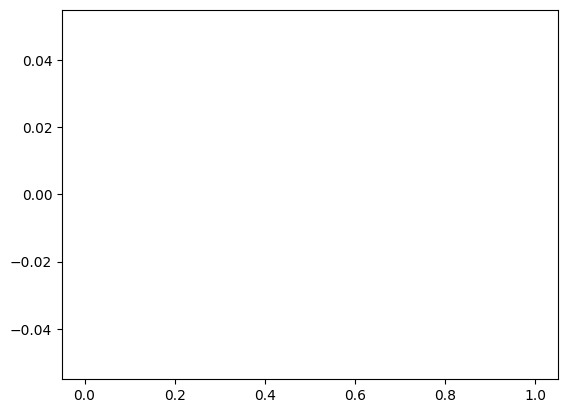

1
1
path stat calc complete 0.06051206588745117
network for period: 1891 to 1901
calculating shortest path stats
3


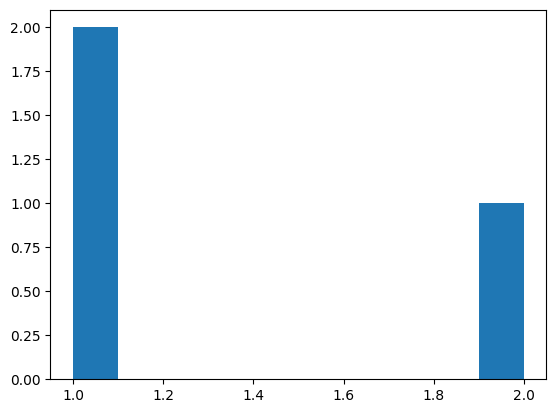

1
1
path stat calc complete 0.044309139251708984
network for period: 1901 to 1911
calculating shortest path stats
3


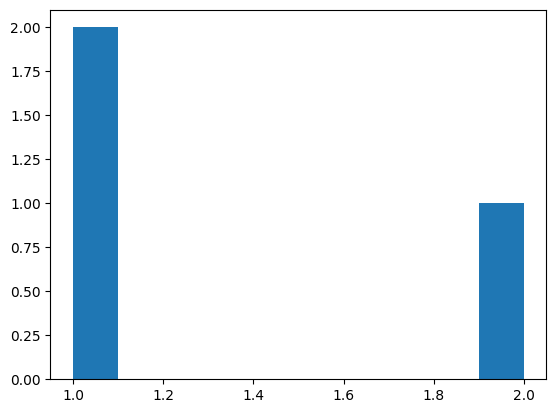

1
1
path stat calc complete 0.04375910758972168
network for period: 1911 to 1921
calculating shortest path stats
21736


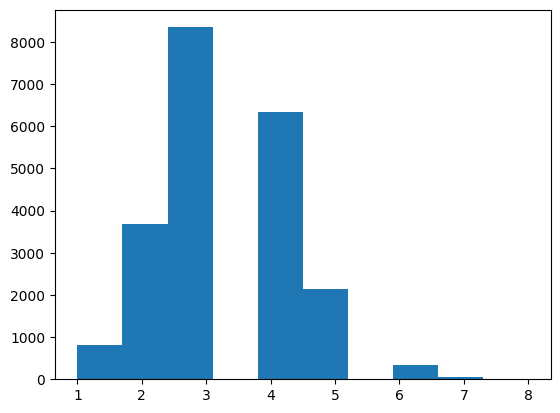

55
28
path stat calc complete 0.16898298263549805
network for period: 1921 to 1931
calculating shortest path stats
3486


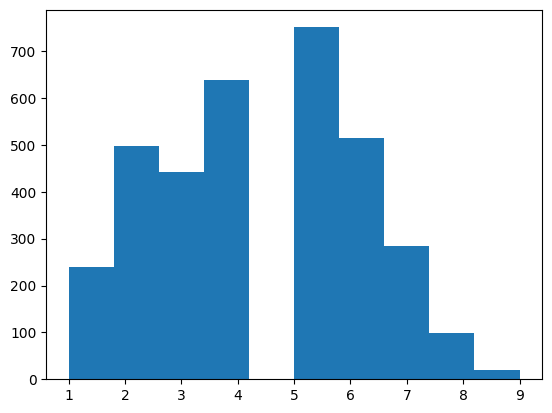

435
406
path stat calc complete 0.06361007690429688
network for period: 1931 to 1941
calculating shortest path stats
17578


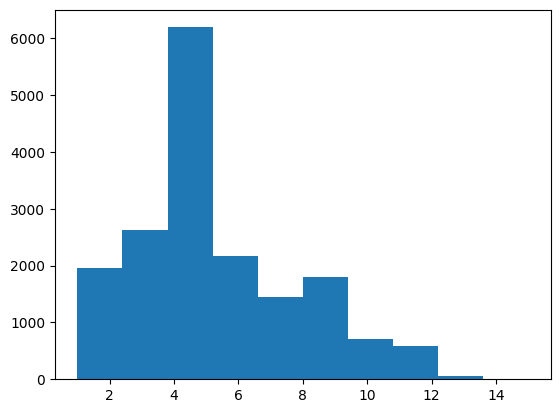

120
55
path stat calc complete 0.13292694091796875
network for period: 1941 to 1951
calculating shortest path stats
15576


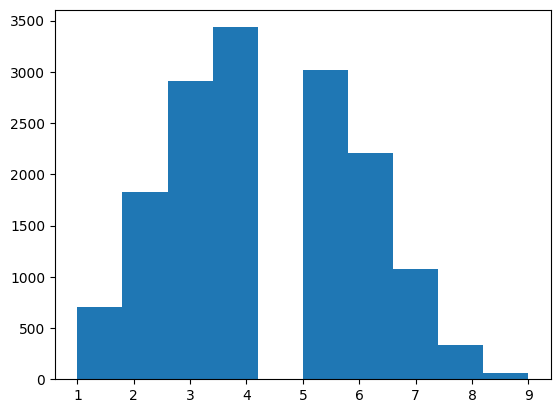

1711
595
path stat calc complete 0.141815185546875
network for period: 1951 to 1961
calculating shortest path stats
11935


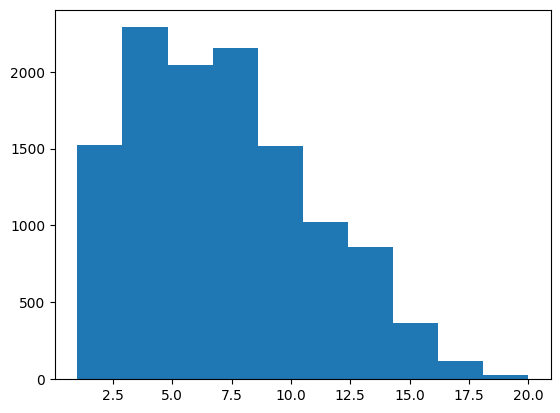

528
78
path stat calc complete 0.11522316932678223
network for period: 1961 to 1971
calculating shortest path stats
34716


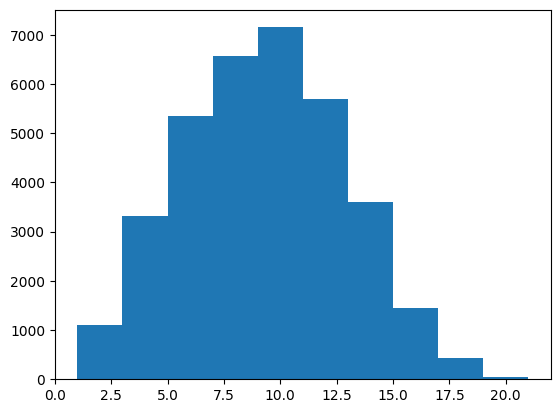

406
136
path stat calc complete 0.18502593040466309
network for period: 1971 to 1981
calculating shortest path stats
15931


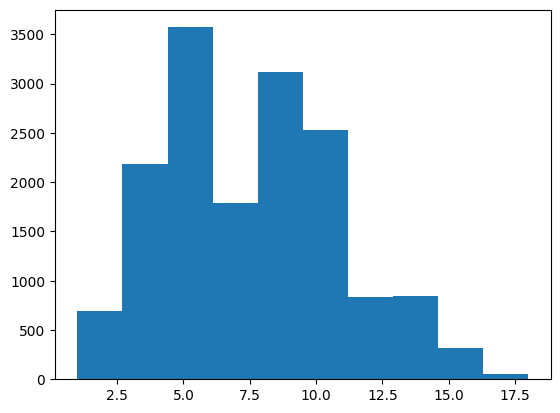

1485
210
path stat calc complete 0.11105203628540039
network for period: 1981 to 1991
calculating shortest path stats
186966


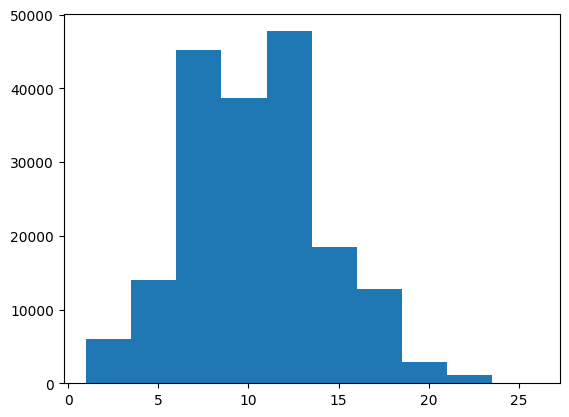

351
120
path stat calc complete 0.7635536193847656
network for period: 1991 to 2001
calculating shortest path stats
404550


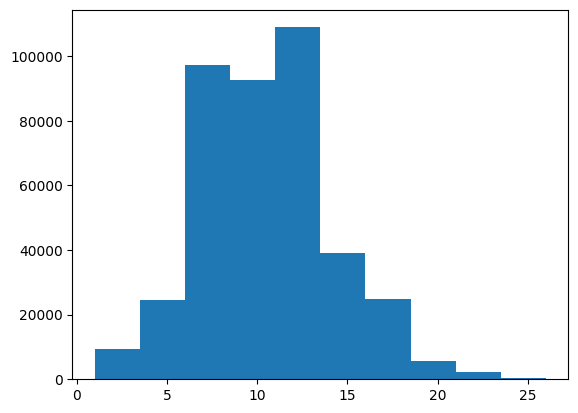

435
276
path stat calc complete 1.6906659603118896
network for period: 2001 to 2011
calculating shortest path stats
1585090


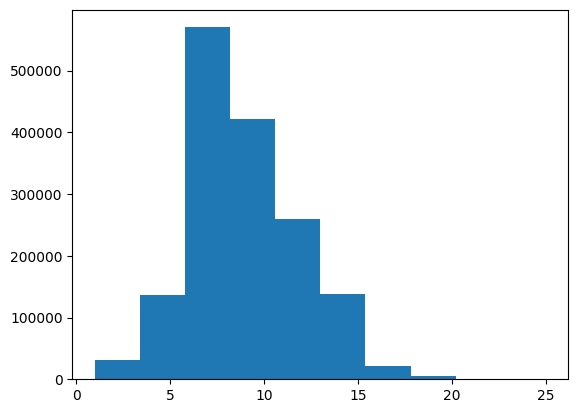

78
78
path stat calc complete 6.818339109420776
network for period: 2011 to 2021
calculating shortest path stats
4288056


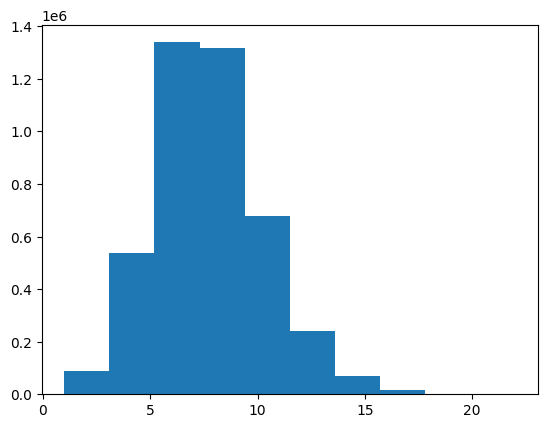

91
91
path stat calc complete 19.641318798065186


In [107]:
networks={}
j=0
data=[]
for i in range(1881,2021,10):
    if (i+10)>2021:
        break;
    print("network for period: "+str(i)+ " to "+ str(i+10))
    content_restrict={"Article":0, "Review":0, "MISC":1, "Comment":0, "Reply":0, "Review2":0, "Discussion":0, "Rejoinder":0}
    output=build_graph(i, i+10, "a1", content_restrict)
    networks[j]={"graph":output[0], "start":i, "end": i+10}
    op=calc_network_stats(output[0])
    op["start"]=i
    op['end']=i+10
    data.append(op)
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+10)+"_"+str(time.time())+".gexf")



In [108]:
df=pd.DataFrame(data)
df.to_excel("rolling_10Y_network_summary_"+str(time.time())+".xlsx", index=False)    
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

df

,Number of nodes,Number of edges,Number of CC,LCC,LCC %,2nd LCC,2nd LCC %,3rd LCC,3rd LCC %,AVG clustering,AVG clustering rnd,centers of LCC,AVG degree,degree std,isolated authors,isolated authors %,LCC avg shortest path,LCC std shortest path,2nd LCC avg shortest path,2nd LCC std shortest path,3rd LCC avg shortest path,3rd LCC std shortest path,start,end
0,63,3,60,2,3.175,2,3.175,2,3.175,0.00000,0.00000,"[uriel h. crocker, s. m. macvane]",0.09524,0.29590,57,90.476,NaN,NaN,NaN,NaN,NaN,NaN,1881,1891
1,311,10,301,3,0.965,2,0.643,2,0.643,0.00000,0.00000,[w. j. a.],0.06431,0.25849,292,93.891,1.33333,0.57735,NaN,NaN,NaN,NaN,1891,1901
2,413,10,403,3,0.726,2,0.484,2,0.484,0.00000,0.00000,[william d. stewart],0.04843,0.22594,394,95.400,1.33333,0.57735,NaN,NaN,NaN,NaN,1901,1911
3,1042,904,795,209,20.058,11,1.056,8,0.768,0.18123,0.01419,"[roy g. blakey, e. d. durand, j. m. clark]",1.73512,4.20567,775,74.376,3.30075,1.04834,1.43636,0.50050,1.21429,0.41786,1911,1921
4,1037,585,796,84,8.100,30,2.893,29,2.797,0.19070,0.00521,"[sumner h. slichter, john d. black]",1.12825,2.45853,749,72.228,4.27940,1.83805,2.25517,0.85690,2.11576,0.72955,1921,1931
5,1753,954,1352,188,10.724,16,0.913,11,0.627,0.16386,0.00334,"[william orton, michael t. florinsky, calvin b. hoover]",1.08842,2.48871,1263,72.048,5.23882,2.50558,1.89167,0.79701,1.00000,0.00000,1931,1941
6,2011,1355,1521,177,8.802,59,2.934,35,1.740,0.15862,0.00654,"[jules backman, joseph j. spengler, morris a. copeland, dexter m. keezer, joseph s. davis, dickson h. leavens, frederick c. mills, seymour e. harris, albert b. wolfe, aryness j. wickens, e. a. goldenweiser, edward chamberlin, eveline m. burns, edward s. mason, donald h. wallace, paul t. homan, frank h. knight, norman s. buchanan, fritz machlup]",1.34759,3.44307,1410,70.114,4.23658,1.68535,3.86090,1.98899,2.54286,1.06019,1941,1951
7,2583,1241,2001,155,6.001,33,1.278,13,0.503,0.12166,0.12166,[melvin g. d. chazeau],0.96090,3.41166,1789,69.261,7.01315,3.98122,4.26136,2.03010,2.20513,0.87325,1951,1961
8,3316,1144,2406,264,7.961,29,0.875,17,0.513,0.10497,0.10497,"[herbert stein, challis a. hall]",0.68999,1.19619,2054,61.942,8.79309,3.56265,4.12808,1.81580,2.53676,0.91820,1961,1971
9,3735,1670,2317,179,4.793,55,1.473,21,0.562,0.11860,0.11860,[joseph e. stiglitz],0.89424,1.10910,1646,44.070,7.61886,3.26660,5.93199,2.91849,2.96667,1.29550,1971,1981


<Axes: title={'center': 'Comparing number of nodes with number of edges, number of isolated authors and number of nodes in the giant connected component'}, xlabel='Period', ylabel='Units'>

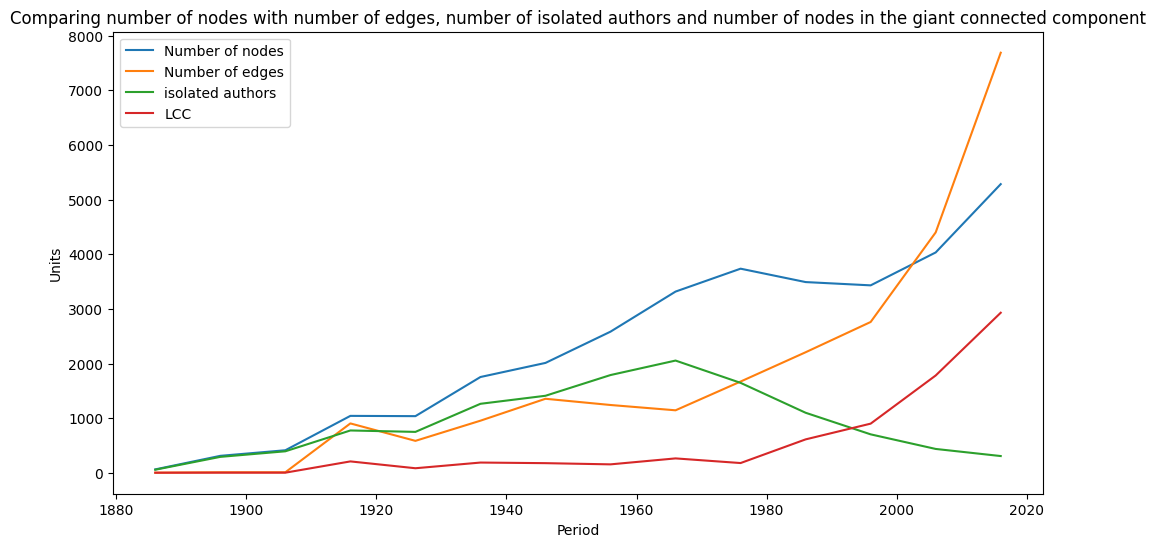

In [109]:
# df[["Number of nodes","Number of edges","isolated authors"]].set_index(df["end"]).plot(x_label=)
# temp=(df["start"].astype(str)+"-"+df["end"].astype(str).str[-2:])
temp=(df["start"]+df["end"])/2

df[["Number of nodes","Number of edges","isolated authors","LCC"]].set_index(temp).plot(figsize = (12, 6), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Comparing number of nodes with number of edges, number of isolated authors and number of nodes in the giant connected component")

<Axes: title={'center': 'Comparing number of nodes with number of edges'}, xlabel='Period', ylabel='Units'>

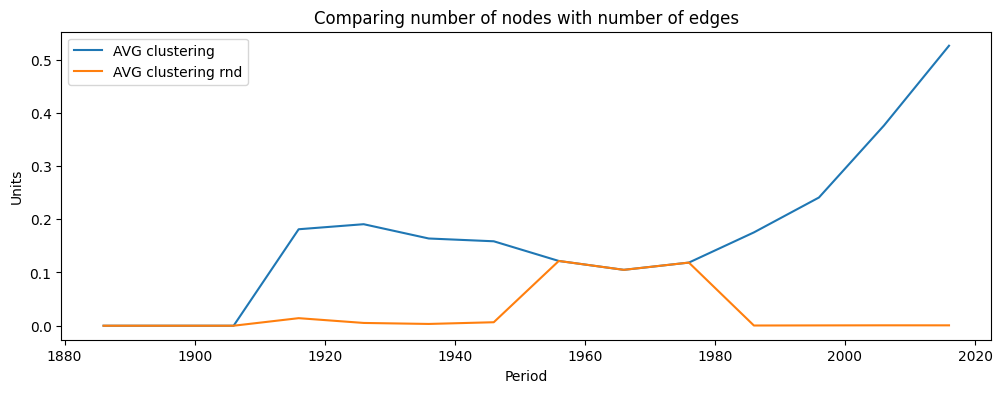

In [110]:
df[["AVG clustering","AVG clustering rnd"]].set_index(temp).plot(figsize = (12, 4), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Comparing number of nodes with number of edges")

<Axes: title={'center': 'Considering distance in the Giant Component'}, xlabel='Period', ylabel='Units'>

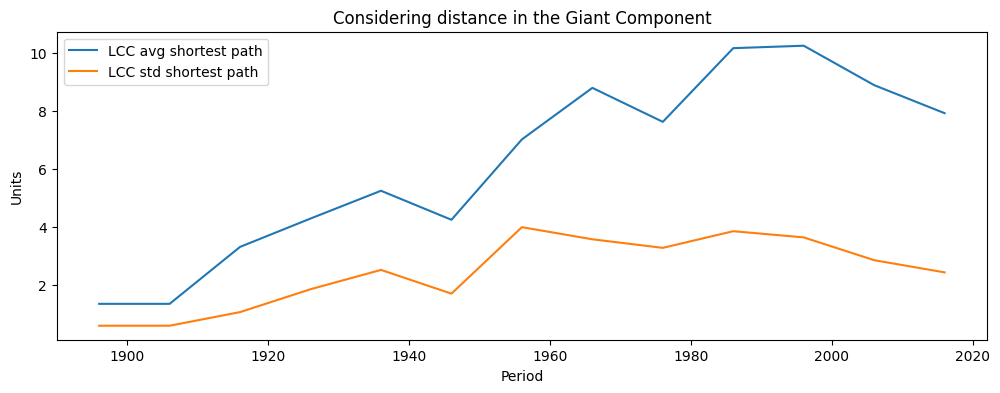

In [111]:
df[["LCC avg shortest path", "LCC std shortest path"]].set_index(temp).plot(figsize = (12, 4), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Considering distance in the Giant Component")

1. number of nodes is very large compared to the average number of coauthors
2. the network is integrated; a giant component exists and covers a large share of the population
3. the average distance between nodes in the giant component is small: ie: the average distance is of order ln(n).
4. clustering is high such that the clustering coefficient is much larger than the average number of coauthors

In [362]:
# the ugliest donut shaped graphs ever.
def plot_a_net(L, start, end):
    plt.figure()
    text="network graph of econ journal authors between "+str(start)+" and "+str(end)+" (exclusive). Nodes="+str(L.number_of_nodes())+". Edges="+str(L.number_of_edges())+'.'
    plt.title(text)
    nx.draw_spectral(L, with_labels=True, font_weight='light', node_size=5, font_size=5)
    plt.show()